In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from PIL import Image
import timeit,time
import math
import pandas as pd

from skimage import measure
from scipy import ndimage as ndi
from skimage import feature

c:\users\narendra\.conda\envs\tensorflow\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [ ]:
# load the model
#path = '/home/grads/n/narendra5/Desktop/Programs/LER_machine_learning/'
path = r"C:\\Users\\narendra\\Documents\\LER\\LER_machine_learning\\"
#model = load_model(path + r'models\\' + 'full_run1_epoch_4.h5')

#model = load_model(path + 'models/' + 'full_run1_epoch_4.h5')
model = load_model(path + 'models\' + 'SEMNet_run2_epoch_4.h5')
model.summary()

In [80]:
"""
Entire Test set 

sigmas = [0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8]
Xis = [10, 30, 40]
alphas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
widths = [20, 30]
noises = [2, 3, 4, 5, 10, 20, 30, 50, 100, 200]
"""

sigmas = [0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8]
Xis = [10, 30, 40]
alphas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
widths = [20, 30]
noises = [2, 3, 4, 5, 10, 20, 30, 50, 100, 200]

testsize = len(sigmas)*len(Xis)*len(alphas)*len(widths)*len(noises)*2*5
print('Testsize: ', testsize)


df = pd.DataFrame(columns = ['noise', 'sigma', 'alpha', 'Xi', 'width', 'space', 'canny_sigma', \
                             'MSE_noise','MSE_pred', 'PSNR_noise','PSNR_pred', 'Pred_time', \
                             'leftline_sigma', 'rightline_sigma', 'ledge_orig_sigma', 'ledge_pred_sigma', \
                             'redge_orig_sigma', 'redge_pred_sigma', 'lorig_mabse', 'lpred_mabse', 'rorig_mabse', \
                             'rpred_mabse', 'ldiff_mabse','rdiff_mabse', 'line_LWR', 'orig_LWR', 'pred_LWR'])

count = 0
for sigma in sigmas:
    for alpha in alphas:
        for Xi in Xis:
            for width in widths:
                for s in range(2):
                    for noise in noises:
                        space = math.floor(width*2**s)
                        shift = math.floor(-25 + (width + space/2 + Xi + alpha*10 + sigma*10)%16) 
                        
                        original_file = path + 'original_images2/oim_' + "{:.2g}".format(sigma*1e-09) + '_' + str(alpha) + '_' + "{0:.2g}".format(Xi*1e-09) + '_' + str(width) + '_' + str(space) + '_' + str(-shift) + '.tiff'
                        noisy_file = path + 'noisy_images2/nim_' + "{0:.2g}".format(sigma*1e-09) + '_' + str(alpha) + '_' + "{0:.2g}".format(Xi*1e-09) + '_' + str(width) + '_' + str(space) + '_' + str(-shift) + '_' + str(noise) + '.tiff'
                        linescan_file = path + 'linescans/linescan_' + "{:.2g}".format(sigma*1e-09) + '_' + str(alpha) + '_' + "{0:.2g}".format(Xi*1e-09) + '_' + str(width) + '_' + str(space) + '.txt'
                        linescan = []
                        with open(linescan_file,'r') as f:
                            for line in f:
                                a, b = line.split(',')
                                linescan.append(float(b))
                        
                        linescan = linescan[:2048]
                        
                        leftline = np.array(linescan[:1024]) 
                        rightline = linescan[1024:]
                        rightline.reverse()
                        rightline = np.array(rightline)

                        leftline = leftline + shift           # add shift to linescan
                        rightline = rightline + shift         # add shift to linescan
                        
                        leftline = leftline.round()[1:1023]    # Round and 
                        rightline = rightline.round()[1:1023]
                        
                        im = np.array(Image.open(original_file))
                        imnoisy = np.array(Image.open(noisy_file))
                        
                        im = im/256
                        imnoisy = imnoisy/256
                        imnoisy = imnoisy.reshape(1,1024,64,1)
                        im = im.reshape(1,1024,64,1)
                        
                        start = time.time()
                        impredict = model.predict(imnoisy)
                        prediction_time = time.time() - start
                        
                        
                        impredict = impredict.reshape(1024,64)
                        imnoisy = imnoisy.reshape(1024,64)
                        im = im.reshape(1024,64)
                        impredict = impredict.astype(float)
                        imnoisy = imnoisy.astype(float)
                        im = im.astype(float)
                        
                        mse_predict = (256**2)*((im - impredict) ** 2).mean()
                        mse_noisy = (256**2)*((im - imnoisy) ** 2).mean()
                        
                        psnr_noisy = measure.compare_psnr(im,imnoisy)
                        psnr_predict = measure.compare_psnr(im,impredict)
                        
                        canny_sigmas = [0, 0.5, 1, 2, 3]
                        for canny_sigma in canny_sigmas:
                            edges_im = feature.canny(im, sigma = canny_sigma)
                            edges_imnoisy = feature.canny(imnoisy, sigma = canny_sigma)
                            edges_impredict = feature.canny(impredict, sigma = canny_sigma)
                        
                            ledge_orig = 1 + np.argmax(edges_im, axis = 1)[1:1023]
                            redge_orig = np.argmax(np.fliplr(edges_im), axis = 1)[1:1023]
                            redge_orig = 63 - redge_orig
                        
                            ledge_pred = 1 + np.argmax(edges_impredict, axis = 1)[1:1023]
                            redge_pred = np.argmax(np.fliplr(edges_impredict), axis = 1)[1:1023]
                            redge_pred = 63 - redge_pred
                        
                            lorig_mabse = np.abs((leftline - ledge_orig)).sum()
                            rorig_mabse = np.abs((rightline - redge_orig)).sum()
                        
                            lpred_mabse = np.abs((leftline - ledge_pred)).sum()
                            rpred_mabse = np.abs((rightline - redge_pred)).sum()
                        
                            ldiff_mabse = np.abs((ledge_orig - ledge_pred)).sum()
                            rdiff_mabse = np.abs((redge_orig - redge_pred)).sum()
                            
                            line_LWR = np.abs((rightline - leftline)).std()/2
                            orig_LWR = np.abs((redge_orig - ledge_orig)).std()/2
                            pred_LWR = np.abs((redge_pred - ledge_pred)).std()/2
                            
                            df.loc[count] = [noise, sigma, alpha, Xi, width, space, canny_sigma, \
                                             mse_noisy, mse_predict, psnr_noisy, psnr_predict, prediction_time, \
                                             leftline.std()/2, rightline.std()/2, \
                                             ledge_orig.std()/2, ledge_pred.std()/2, redge_orig.std()/2, \
                                             redge_pred.std()/2, lorig_mabse, lpred_mabse, rorig_mabse, \
                                             rpred_mabse, ldiff_mabse, rdiff_mabse, line_LWR, orig_LWR, pred_LWR]
                        
                            count += 1
                        
print("Test count: ", count)
#print(df)

Testsize:  43200
Test count:  43200


In [2]:
df.to_csv(path + 'Test_results.csv')

NameError: name 'df' is not defined

In [4]:
path = '/home/grads/n/narendra5/Desktop/Programs/LER_machine_learning/'
df = pd.DataFrame.from_csv(path + 'Test_results.csv')

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  


In [3]:
print(df.loc[(df['noise'] == 10) & (df['sigma'] == 0.8) & (df['alpha'] == 0.3) & (df['Xi'] == 10) & (df['width'] == 20) & (df['space'] == 20)])

       noise  sigma  alpha    Xi  width  space  canny_sigma    MSE_noise  \
12020   10.0    0.8    0.3  10.0   20.0   20.0          0.0  1507.162048   
12021   10.0    0.8    0.3  10.0   20.0   20.0          0.5  1507.162048   
12022   10.0    0.8    0.3  10.0   20.0   20.0          1.0  1507.162048   
12023   10.0    0.8    0.3  10.0   20.0   20.0          2.0  1507.162048   
12024   10.0    0.8    0.3  10.0   20.0   20.0          3.0  1507.162048   

       MSE_pred  PSNR_noise    ...     redge_pred_sigma  lorig_mabse  \
12020  89.21485     16.3832    ...             0.692732        381.0   
12021  89.21485     16.3832    ...             0.686634        392.0   
12022  89.21485     16.3832    ...             0.662986        424.0   
12023  89.21485     16.3832    ...             0.594220        648.0   
12024  89.21485     16.3832    ...             0.546505       1005.0   

       lpred_mabse  rorig_mabse  rpred_mabse  ldiff_mabse  rdiff_mabse  \
12020        438.0        578.0     

In [5]:
sigmas = [0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8]
Xis = [10, 30, 40]
alphas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
widths = [20, 30]
noises = [2, 3, 4, 5, 10, 20, 30, 50, 100, 200]

35051    10.279854
35056    11.688678
35061    12.807815
35066    13.666754
35071    16.327268
35076    19.250881
35081    20.954069
35086    23.120070
35091    26.134251
35096    29.083603
Name: PSNR_noise, dtype: float64


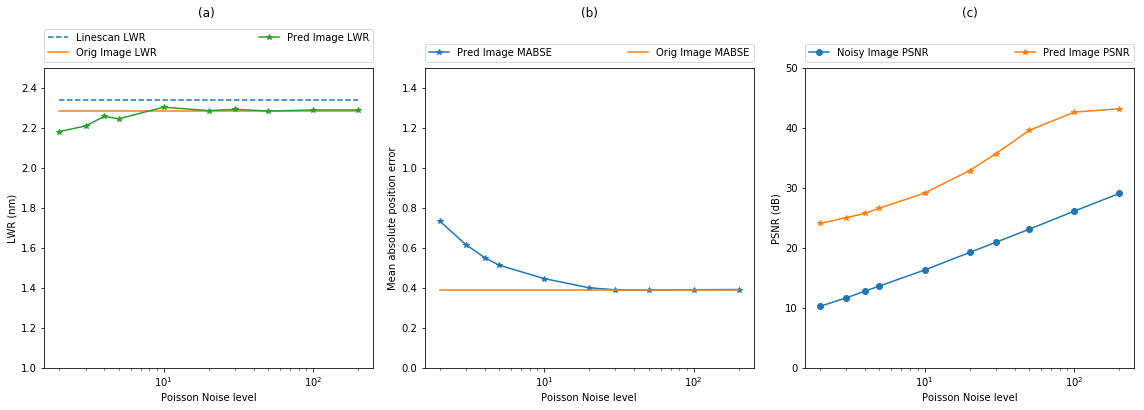

In [51]:
%matplotlib inline
df1 = df.loc[(df['sigma'] == 1.6) & (df['alpha'] == 0.5) & (df['Xi'] == 30) & (df['width'] == 20) \
             & (df['space'] == 40) & (df['canny_sigma'] == 0.5)]
"""
ax = df1.plot(x = 'noise', y = 'ledge_pred_sigma', style = '-o', logx = True, ylim = (0.6,1.6))
df1.plot(x = 'noise', y = 'ledge_orig_sigma', style = '-*', ax = ax, logx = True)
df1.plot(x = 'noise', y = 'leftline_sigma', style = '-*', ax = ax, logx = True)

ax = df1.plot(x = 'noise', y = 'redge_pred_sigma', style = '-o', logx = True, ylim = (0.6, 1.6))
df1.plot(x = 'noise', y = 'redge_orig_sigma', style = '-*', ax = ax, logx = True)
df1.plot(x = 'noise', y = 'rightline_sigma', style = '-*', ax = ax, logx = True)

ax = df1.plot(x = 'noise', y = 'lpred_mabse', style = '-o', logx = True)
df1.plot(x = 'noise', y = 'lorig_mabse', style = '-*', ax = ax, logx = True)
"""

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 6), subplot_kw={'adjustable': 'box-forced'})

print(df1['PSNR_noise'])

ax[0].plot(noises, df1['line_LWR'],'--', label = 'Linescan LWR')
ax[0].plot(noises, df1['orig_LWR'],'-', label = 'Orig Image LWR')
ax[0].plot(noises, df1['pred_LWR'],'-*', label = 'Pred Image LWR')
ax[0].set_xscale('log')
ax[0].set_ylabel('LWR (nm)')
ax[0].set_xlabel('Poisson Noise level')
ax[0].set_title('(a) ', y = 1.15)
ax[0].set_ylim(1.0,2.5)
ax[0].legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)

ax[1].plot(noises, (df1['lpred_mabse'] + df1['rpred_mabse'])/2044,'-*', label = 'Pred Image MABSE')
ax[1].plot(noises, (df1['lorig_mabse'] + df1['rorig_mabse'])/2044,'-', label = 'Orig Image MABSE')
ax[1].set_xscale('log')
ax[1].set_ylabel('Mean absolute position error')
ax[1].set_xlabel('Poisson Noise level')
ax[1].set_ylim(0,1.5)
ax[1].set_title('(b)', y = 1.15)
ax[1].legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)

ax[2].plot(noises, df1['PSNR_noise'],'-o', label = 'Noisy Image PSNR')
ax[2].plot(noises, df1['PSNR_pred'],'-*', label = 'Pred Image PSNR')
ax[2].set_xscale('log')
ax[2].set_ylabel('PSNR (dB)')
ax[2].set_xlabel('Poisson Noise level')
ax[2].set_ylim(0,50)
ax[2].set_title('(c)', y = 1.15)
ax[2].legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)

plt.tight_layout()
plt.subplots_adjust(top=0.8)
#plt.savefig('plot_image_3.png')
plt.show()

[11160, 22320, 33480, 44640]


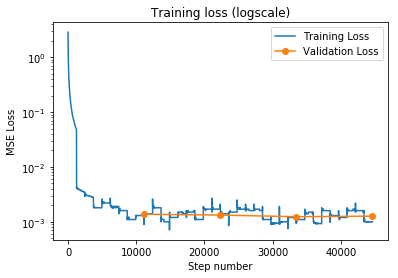

range(11160, 55800, 11160)


In [30]:
%matplotlib inline
logfile = path + 'neural_nets/SEMNet_run2_epoch4.688288'
losses = []
validation_score = []
with open(logfile,'r') as f:
    for line in f:
        if 'loss' in line:
            losses.append(float(line.split()[-1]))
        if 'Validation score' in line:
            validation_score.append(float(line.split()[-1]))

num_of_runs = range(len(losses))
val_runs = range(len(losses)//4, len(losses) + len(losses)//4, len(losses)//4)
print(list(val_runs))
plt.plot(num_of_runs, losses, label = 'Training Loss')
plt.plot(val_runs, validation_score, '-o', label = 'Validation Loss')
plt.ylabel('MSE Loss')
plt.xlabel('Step number')
plt.title('Training loss (logscale)')
plt.yscale('log')
plt.savefig(path + 'Training_loss.png')
plt.legend()
plt.show()
print(val_runs)

(0, 25)

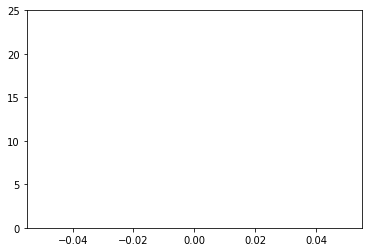

In [74]:
df1 = df.loc[(df['canny_sigma'] == 0.5) & (df['sigma'] == 20) &(df['alpha'] == 0.5)]
plt.plot(df1['PSNR_pred'] - df1['PSNR_noise'])
plt.ylim(0,25)